In [1]:
import tensorflow as tf
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import glob

In [2]:
img=glob.glob(r'D:\Study\深度学习\日月光华-tensorflow入门与实战资料\数据集\UNET语义分割\城市街景数据集\images\train\*\*.png')

In [3]:
len(img)

2975

In [4]:
label=glob.glob(r'D:\Study\深度学习\日月光华-tensorflow入门与实战资料\数据集\UNET语义分割\城市街景数据集\gtFine分割图\train\*\*_gtFine_labelIds.png')

In [5]:
train_count=len(label)

In [6]:
index= np.random.permutation(len(img))

In [7]:
img=np.array(img)[index]
label=np.array(label)[index]

In [8]:
img_val=glob.glob(r'D:\Study\深度学习\日月光华-tensorflow入门与实战资料\数据集\UNET语义分割\城市街景数据集\images\val\*\*.png')
label_val=glob.glob(r'D:\Study\深度学习\日月光华-tensorflow入门与实战资料\数据集\UNET语义分割\城市街景数据集\gtFine分割图\val\*\*_gtFine_labelIds.png')

In [9]:
validation_count=len(label_val)

In [10]:
dataset_train=tf.data.Dataset.from_tensor_slices((img,label))

In [11]:
dataset_train

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [12]:
dataset_val=tf.data.Dataset.from_tensor_slices((img_val,label_val))

In [13]:
def read_png(path):
    img= tf.io.read_file(path)
    img= tf.image.decode_png(img,channels=3)
    return img

In [14]:
def read_png_label(path):
    img= tf.io.read_file(path)
    img= tf.image.decode_png(img,channels=1)
    return img

In [15]:
img_1=read_png(img[0])
label_1=read_png_label(label[0])

In [16]:
img_1.shape

TensorShape([1024, 2048, 3])

In [17]:
label_1.shape

TensorShape([1024, 2048, 1])

# 数据增强

1. 随机翻转 img=tf.image.flip_left_right()

2. 随机裁剪

In [18]:
concat_image=tf.concat([img_1,label_1],axis=-1)

In [19]:
concat_image.shape

TensorShape([1024, 2048, 4])

In [20]:
def crop_img(img,mask):
    concat_image=tf.concat([img,mask],axis=-1)
    concat_image=tf.image.resize(concat_image,(280,280),
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img=tf.image.random_crop(concat_image,[256,256,4])
    return crop_img[:,:,:3], crop_img[:,:,3:]

In [21]:
img_1,label_1 = crop_img(img_1,label_1)

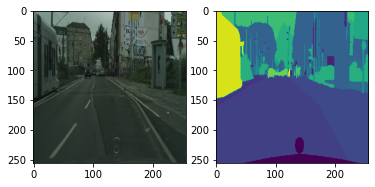

In [22]:
plt.subplot(1,2,1)
plt.imshow(img_1.numpy())
plt.subplot(1,2,2)
plt.imshow(np.squeeze(label_1.numpy()))

In [23]:
def normalization(img, mask):
    img = tf.cast(img,tf.float32)/127.5-1
    mask=tf.cast(mask,tf.int32)
    return img,mask

In [24]:
def load_img_train(img_path,mask_path):
    img=read_png(img_path)
    mask=read_png_label(mask_path)
    
    img,mask=crop_img(img,mask)
    
    if tf.random.uniform(())>0.5:
        img=tf.image.flip_left_right(img)
        mask=tf.image.flip_left_right(mask)
    
    img,mask=normalization(img,mask)
    return img, mask

In [25]:
def load_img_val(img_path,mask_path):
    img=read_png(img_path)
    mask=read_png_label(mask_path)
    
    img=tf.image.resize(img,(256,256))
    mask=tf.image.resize(img,(256,256))
    
    img,mask=normalization(img,mask)
    return img, mask

In [26]:
Batch_size=32
Buffer_size= 300
step_per_epoch=train_count//Batch_size
val_step=validation_count//Batch_size

In [27]:
auto =tf.data.experimental.AUTOTUNE

In [28]:
dataset_train = dataset_train.map(load_img_train,num_parallel_calls=auto)
dataset_val = dataset_val.map(load_img_val,num_parallel_calls=auto)

In [29]:
dataset_train = dataset_train.cache().repeat().shuffle(Buffer_size).batch(Batch_size).prefetch(auto)
dataset_val = dataset_train.cache().repeat().batch(Batch_size)

# 定义Unet模型

In [30]:
def create_model():
    #下采样
    inputs=tf.keras.layers.Input(shape=(256,256,3))
    
    x=tf.keras.layers.Conv2D(64,3, padding='same', activation='relu')(inputs)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Conv2D(64,3, padding='same', activation='relu')(x)
    x=tf.keras.layers.BatchNormalization()(x) #256,256,64
    
    x1=tf.keras.layers.MaxPooling2D(padding='same')(x) #128,128,64
    
    x1=tf.keras.layers.Conv2D(128,3, padding='same', activation='relu')(x1)
    x1=tf.keras.layers.BatchNormalization()(x1) #128,128,128    
    x1=tf.keras.layers.Conv2D(128,3, padding='same', activation='relu')(x1)
    x1=tf.keras.layers.BatchNormalization()(x1) #128,128,128      
    
    x2=tf.keras.layers.MaxPooling2D(padding='same')(x1) #64,64,128
    
    x2=tf.keras.layers.Conv2D(256,3, padding='same', activation='relu')(x2)
    x2=tf.keras.layers.BatchNormalization()(x2)  
    x2=tf.keras.layers.Conv2D(256,3, padding='same', activation='relu')(x2)
    x2=tf.keras.layers.BatchNormalization()(x2) #64,64,256
    
    x3=tf.keras.layers.MaxPooling2D(padding='same')(x2) #32,32,256
    
    x3=tf.keras.layers.Conv2D(512,3, padding='same', activation='relu')(x3)
    x3=tf.keras.layers.BatchNormalization()(x3)  
    x3=tf.keras.layers.Conv2D(512,3, padding='same', activation='relu')(x3)
    x3=tf.keras.layers.BatchNormalization()(x3) #32,,32,512
    
    x4=tf.keras.layers.MaxPooling2D(padding='same')(x3) #16,16,512
    
    x4=tf.keras.layers.Conv2D(1024,3, padding='same', activation='relu')(x4)
    x4=tf.keras.layers.BatchNormalization()(x4)  
    x4=tf.keras.layers.Conv2D(1024,3, padding='same', activation='relu')(x4)
    x4=tf.keras.layers.BatchNormalization()(x4) #16.16,1024
    
    #上采样
    
    x5=tf.keras.layers.Conv2DTranspose(512,2,strides=2,padding='same', activation='relu')(x4)
    x5=tf.keras.layers.BatchNormalization()(x5) #32,32,512
    
    x6=tf.concat([x3,x5],axis=-1) #32,32,1024
    
    x6=tf.keras.layers.Conv2D(512,3, padding='same', activation='relu')(x6)
    x6=tf.keras.layers.BatchNormalization()(x6)  
    x6=tf.keras.layers.Conv2D(512,3, padding='same', activation='relu')(x6)
    x6=tf.keras.layers.BatchNormalization()(x6) #32,32,512
    
    x7=tf.keras.layers.Conv2DTranspose(256,2,strides=2,padding='same', activation='relu')(x6)
    x7=tf.keras.layers.BatchNormalization()(x7) #64,64,256
    
    x8=tf.concat([x7,x2],axis=-1) #64,64,512
    
    x8=tf.keras.layers.Conv2D(256,3, padding='same', activation='relu')(x8)
    x8=tf.keras.layers.BatchNormalization()(x8)  
    x8=tf.keras.layers.Conv2D(256,3, padding='same', activation='relu')(x8)
    x8=tf.keras.layers.BatchNormalization()(x8) #64,64,256
    
    x9=tf.keras.layers.Conv2DTranspose(128,2,strides=2,padding='same', activation='relu')(x8)
    x9=tf.keras.layers.BatchNormalization()(x9) #128,128,128
    
    x10=tf.concat([x9,x1],axis=-1) #128,128,256
    
    x10=tf.keras.layers.Conv2D(128,3, padding='same', activation='relu')(x10)
    x10=tf.keras.layers.BatchNormalization()(x10)  
    x10=tf.keras.layers.Conv2D(128,3, padding='same', activation='relu')(x10)
    x10=tf.keras.layers.BatchNormalization()(x10) #128,128,128
    
    x11=tf.keras.layers.Conv2DTranspose(64,2,strides=2,padding='same', activation='relu')(x10)
    x11=tf.keras.layers.BatchNormalization()(x11) #256,256,64
    
    x12=tf.concat([x11,x],axis=-1) #256,256,128
    
    x12=tf.keras.layers.Conv2D(64,3, padding='same', activation='relu')(x12)
    x12=tf.keras.layers.BatchNormalization()(x12)  
    x12=tf.keras.layers.Conv2D(64,3, padding='same', activation='relu')(x12)
    x12=tf.keras.layers.BatchNormalization()(x12) #256,256,64
    
    output=tf.keras.layers.Conv2D(34,1, padding='same', activation='softmax')(x12)#256,256,34
    
    return tf.keras.Model(inputs=inputs,outputs=output)

In [31]:
model=create_model()

In [32]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
_______________________________________________________________________________________

In [33]:
tf.keras.utils.plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [34]:
#tf.keras.metrics.MeanIoU(num_classes=34) 独热编码

In [35]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self,y_true,y_pred,sample_weight=None):
        y_pred=tf.argmax(y_pred,axis=-1)
        return super().__call__(y_true,y_pred,sample_weight=sample_weight)

In [36]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['acc',MeanIoU(num_classes=34)])

In [37]:
EPOCHES=60

In [38]:
history=model.fit(dataset_train,
                 epochs=EPOCHES,
                 steps_per_epoch=step_per_epoch,
                  validation_steps=val_step,
                  validation_data=dataset_val
                 )

Epoch 1/60


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[32,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node functional_1/conv2d_transpose_2/conv2d_transpose (defined at <ipython-input-38-15b74f60b501>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[confusion_matrix/stack_1/_90]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[32,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node functional_1/conv2d_transpose_2/conv2d_transpose (defined at <ipython-input-38-15b74f60b501>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_6981]

Function call stack:
train_function -> train_function
